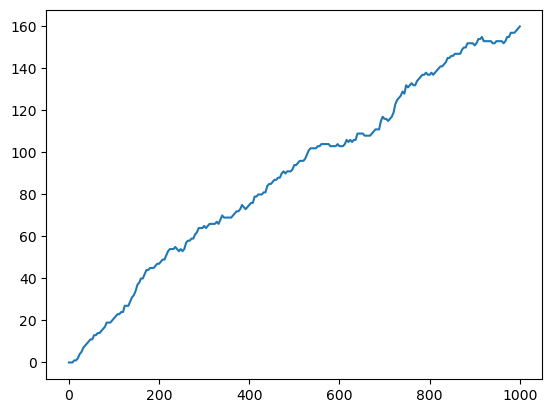

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 21 11:49:19 2022

@author: Anton Grisheshckin

Toggle-Inhibitor-Competition Model
"""
 


#%%Importing packages#
import numpy as np
import matplotlib.pyplot as plt
import functools
#%% Model variables ###
class modelvar :
    # Hill parameters    hr^-1 
    n = 3  # Hill function power in g eqn
    k1 = 2 #[AU]
    k2 = 2 #[AU]
    k3 = 0.1 #[AU]
    ################
    ψ = 0.1 # Max amplification for h [AU]hr^-1
    γ1 = 0.1 #Dilution rate hr^-1
    γ2 = 0.1
    σ1 = 0.02 # Noise amplitudes hr^-1/2
    σ2 = 0.02 
    ##############
    N= 400 # Number of competing genes
    Vtot = 200 #Total maximal amplitude for synthesis across all genes [AU]hr^-1   
    ʎ = 20 # number of silencing events per generation
    gen_length= 72 # Length of a generation in hours
    L=0.3 # 'boost' from the dsRNA trigger
    I= np.zeros(N) #dsRNA trigger "storage" variable
#%% Functions used in the model #

def Hill(top, bottom, power):
    "Creates a Hill function"
    return (top**power)/(top**power+bottom**power)

def mu1(g: float,h : float,  _t: float, MaxAmpl,Trigger) -> float:
    """
    Implement the drift part of the dg equation
    """
    return (Trigger+MaxAmpl*Hill(g,modelvar.k1,modelvar.n)*Hill(modelvar.k2,h,1)-modelvar.γ1*g)

def mu2(g: float, h : float,  _t: float) -> float:
    """
    Implement the drift part of the dh equation
    """
    return (modelvar.ψ*(g/(modelvar.k3+g))-modelvar.γ2*h)

def sigma1(g: float, h:float,  _t: float) -> float:
    """
    Implement the BM part of dg equation
    """
    return modelvar.σ1 * g

def sigma2(g: float, h:float,  _t: float) -> float:
    """
    Implement the BM part of dh equation
    """
    return modelvar.σ2 * h

def dW1(delta_t: float) -> float:
    """
    Sample a random number at each call.
    """
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def dW2(delta_t: float) -> float:
    """
    Sample a random number at each call independent of dW1.
    """
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def run_simulation(initial_time, end_time,time_step,g_array,h_array):
    """
    Return the result of one full simulation.
    Note g and h arrays must be of equal size and correspond to the inital values of g_i and h_i
    """
    DT     = time_step
    TS = np.arange(initial_time, end_time + DT, DT)
    N= len(g_array)
    G=np.zeros((TS.size,N))
    H=np.zeros((TS.size,N))
    G[0]=g_array
    H[0]=h_array
    gene_silencing_threshold=4
    num_silenced_genes= 0
    Step_num=40
    county = 0
    T_array=[0]
    gene_sil_array=[0]
    for s in range(1, TS.size):
        
        t = initial_time + (s - 1) * DT
        #Cost fucntion#
        cost = np.sum(G[s-1])
        ##############
        #Counting silenced genes, not every time for computational speed#
        county=county+1
        if county == Step_num :
            num_silenced_genes = functools.reduce(lambda sum, j: sum  + (1 if j > gene_silencing_threshold else 0), G[s-1], 0)
            T_array.append(t)
            gene_sil_array.append(num_silenced_genes)
            county=0
        #Poisson#
        Events_num = np.random.poisson(DT*modelvar.ʎ/modelvar.gen_length)
        if Events_num != 0 :
            Event_site=np.random.randint(N, size=Events_num)
        else :
            Event_site=[]
            
        for i in range (0,N):
            # working with G[s] and H[s] system at a given timestep#
            if i in Event_site :
                if modelvar.I[i]==modelvar.L :
                    modelvar.I[i]=0
                else :
                    modelvar.I[i]=modelvar.L
            g_old = G[s-1][i]
            h_old = H[s-1][i]
           
            
            #########
            G[s][i] = g_old + mu1(g_old,h_old,t,(modelvar.Vtot/cost),modelvar.I[i]) * DT + sigma1(g_old,h_old,t) * dW1(DT)
            H[s][i]= h_old + mu2(g_old,h_old,t)*DT + sigma2(g_old,h_old,t)*dW2(DT)
    return T_array, gene_sil_array
###############################

#%%#############################

g=0.1*np.ones(modelvar.N)
h=0*np.ones(modelvar.N)

time,gene_silence =run_simulation(0,10000,0.1,g,h)
plt.plot(time,gene_silence)